In [1]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import os

# enable R cells
%load_ext rpy2.ipython

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# requires apt-get install r-base
os.environ["R_HOME"]="/usr/lib/R/"

#### Load Database in R

export to rdf variable

In [2]:
%%R -o rdf
load("Databases/UCR-4.RData.bak")
database[1]
rdf <- data.frame(database);

## Dataset inspection

inspect single examples in python

In [3]:
print(rdf.shape)
print(rdf.columns)

(930, 130)
Index(['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       ...
       'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'tt',
       'c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..'],
      dtype='object', length=130)


field `tt` seems to be the training or test split

In [4]:
print(np.sum(rdf["tt"]==0.0))
print(np.sum(rdf["tt"]==1.0))

30
900


In [5]:
print(pd.unique(rdf["tt"]))
print(pd.unique(rdf["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]))

[0. 1.]
[1. 3. 2.]


**findings/questions**:

the dataset `UCR-4.RData` seems to be `CBF` http://www.timeseriesclassification.com/description.php?Dataset=CBF

* values start from `V2` (where is `V1`?)
* field 'tt' seems to be the training (`0.0`) or test (`1.0`) split
* field `c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..` is likely the label `1` `2` `3`. **It has a a very strange name**, though.

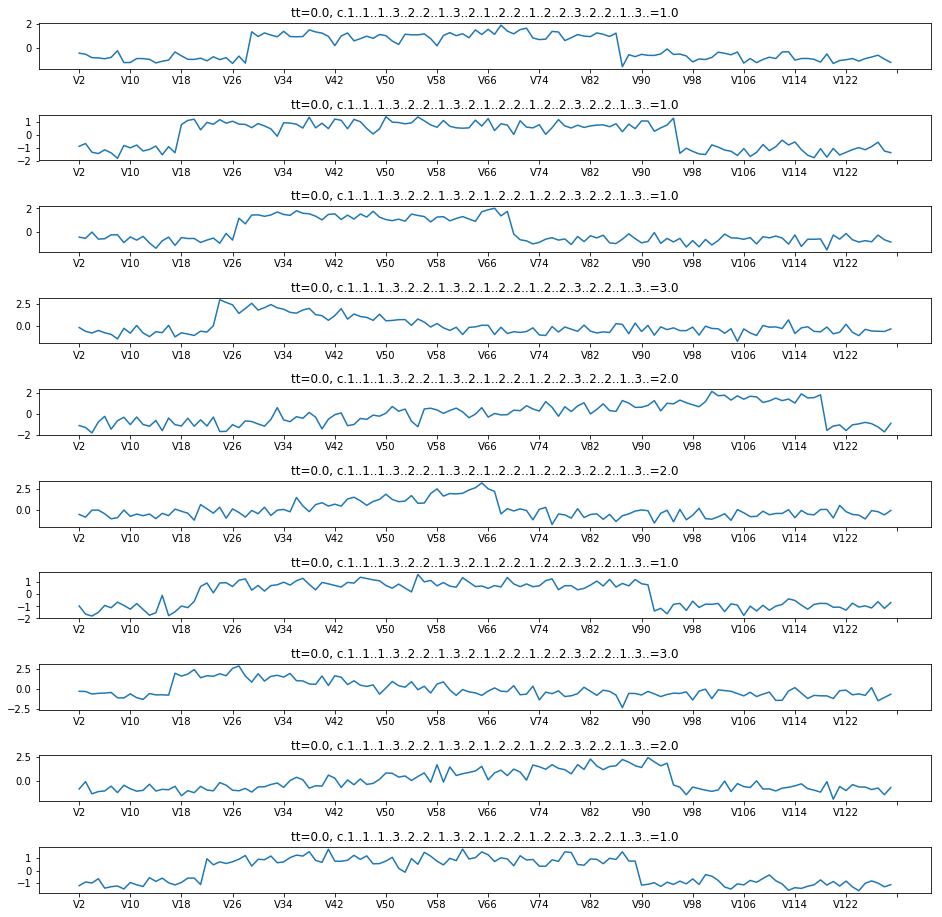

In [6]:
# take only V* columns
values = rdf.filter(regex="V")

n=10
fig,ax = plt.subplots(n,1,figsize=(16,16))
for i in range(n):
    ax[i].plot(values.iloc[i])
    
    tt=rdf.iloc[i]["tt"]
    c=rdf.iloc[i]["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]
    
    title="tt={}, c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..={}".format(tt,c)
    ax[i].set_title(title)
    
    # plot fewer ticks
    ax[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

##### Functions for loading and parsing the BavarianCrops Dataset

In [7]:

def filter_n_times(X, samplet=70):
    """
    X has variable lengths. Hence, it can not be stacked to one numpy array [batchsize x times x n_channels]
    This function randomly chooses <samplet> observations from each X time series and outputs subsabpled
    sequences of fixed size
    the NN implementation does this online whenever a sample is loaded from disk
    """

    new_X = list()
    for X_ in X:
        
        t = X_.shape[0]

        idxs = np.random.choice(t, samplet, replace=False)
        idxs.sort()
        
        new_X.append(X_[idxs])
        
    return np.array(new_X)


def parse_to_format(X, classweights, y, ndims, sequencelengths, sequencelength, ids, tt=0.0):
    N,t,ndims = X.shape
    valuenames = ["V{}".format(t) for t in range(2,t+2)] # V2, V3, V4, ..., VT

    df = pd.DataFrame(X, columns=valuenames)
    df["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."] = y
    df["tt"] = tt
    
    return df

def load_BavarianCrops_dataset(cache, tt, ndvi=True):

    classweights = np.load(os.path.join(cache, "classweights.npy"), allow_pickle=True)
    y = np.load(os.path.join(cache, "y.npy"), allow_pickle=True)
    ndims = int(np.load(os.path.join(cache, "ndims.npy"), allow_pickle=True))
    sequencelengths = np.load(os.path.join(cache, "sequencelengths.npy"), allow_pickle=True)
    sequencelength = sequencelengths.max()

    ids = np.load(os.path.join(cache, "ids.npy"), allow_pickle=True)
    #self.dataweights = np.load(os.path.join(self.cache, "dataweights.npy"))
    X = np.load(os.path.join(cache, "X.npy"), allow_pickle=True)
    """features Sentinel 2 Bands
    ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
       'B8A', 'B9', 'QA10', 'QA20', 'QA60', 'doa', 'label', 'id']"""
    
    X = filter_n_times(X,samplet=70)
    
    # mean aggregate over features to get uni-variate time series
    #X = X.mean(2)
    
    # calculate NDVI to have an univariate TS https://de.wikipedia.org/wiki/Normalized_Difference_Vegetation_Index
    
    #B08 = X[:,:,10] # Near infrared
    #B04 = X[:,:,6] # red channel
    #X = (B08 - B04) / (B08 + B04)
    
    # take only bands
    #X = X[:,:ndims]
    
    #df = parse_to_format(X, classweights, y, ndims, sequencelengths, sequencelength, ids, tt)
    
    tt = np.ones(X.shape[0])*tt
    
    return X, y, tt


In [8]:
X_train, y_train, tt_train = load_BavarianCrops_dataset("Databases/BavarianCrops/train/", tt=0.0)
X_valid, y_valid, tt_valid = load_BavarianCrops_dataset("Databases/BavarianCrops/valid/", tt=0.0)
X_test, y_test, tt_test = load_BavarianCrops_dataset("Databases/BavarianCrops/eval/", tt=1.0)

X = np.vstack([X_train,X_valid,X_test])
classes = np.concatenate([y_train,y_valid,y_test])
tt = np.concatenate([tt_train,tt_valid,tt_test])

### Load the BavarianCrops dataset from npy arrays

In [41]:
X_train, y_train, tt_train = load_BavarianCrops_dataset("Databases/BavarianCrops/train/", tt=0.0)
X_valid, y_valid, tt_valid = load_BavarianCrops_dataset("Databases/BavarianCrops/valid/", tt=0.0)
X_test, y_test, tt_test = load_BavarianCrops_dataset("Databases/BavarianCrops/eval/", tt=1.0)

BavarianCrops = pd.concat([df_train, df_valid, df_test])

train=BavarianCrops.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [ ]:
%%R -i X -i classes


In [100]:
%%R -i X -i classes -i tt
database<-list(X)
database[[1]]$tt = tt
database[[2]] <- classes
save(database, file = "/tmp/BavarianCrops.RData")

In [ ]:
%%R -o train -o classes
load("/tmp/BavarianCrops.RData")
#load("Databases/UCR-4.RData")
train<-database[[1]][database[[1]]$tt==0]
train$tt<-NULL
classes<-as.factor(database[[2]][which(database[[1]]$tt==0)])
train <- data.frame(train);
classes <- data.frame(classes);

In [50]:
train.shape, classes.shape

(            V2        V3        V4        V5        V6        V7        V8  \
 1     0.007570  0.012643  0.005423  0.022730  0.006080  0.043624  0.031439   
 2     0.015020 -0.007701  0.018317  0.043180  0.002611  0.061042  0.030644   
 3     0.045542  0.064986  0.022541  0.001696  0.001322  0.059009  0.072742   
 5    -0.000191  0.004870  0.037075  0.020247  0.014451 -0.000328  0.067940   
 6     0.031789  0.000899  0.024988  0.023740  0.002682  0.056556  0.032956   
 7    -0.005548  0.000428  0.016606  0.021421  0.006971  0.143038  0.029553   
 8     0.036531  0.038533  0.005412  0.009513  0.034533  0.028462  0.057992   
 9     0.000112  0.006096 -0.021606  0.137556  0.214748  0.509693  0.036068   
 10    0.049290 -0.015479  0.021203  0.046657  0.035216  0.076780 -0.007667   
 11   -0.029050  0.032049  0.037260  0.035951 -0.004003 -0.011956  0.035588   
 12    0.042054  0.005344  0.048784  0.006527  0.042441  0.034883 -0.003470   
 13    0.003344  0.012770  0.001927  0.028354  0.005

### save full dataset as .rData

In [10]:
%%R -i train -i classes
database<-list(train)
database[[2]] <- classes
save(database, file = "Databases/BavarianCrops.RData")

### save smaller subset as .rData

In [11]:
BavarianCrops_10 = BavarianCrops.sample(10)
train=BavarianCrops_10.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

In [12]:
%%R -i train -i classes
database<-list(train)
database[[2]] <- classes
save(database, file = "Databases/BavarianCrops_10.RData")

In [13]:
BavarianCrops_100 = BavarianCrops.sample(100)
train=BavarianCrops_100.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

In [14]:
%%R -i train -i classes
database<-list(train)
database[[2]] <- classes
save(database, file = "Databases/BavarianCrops_100.RData")

In [15]:
BavarianCrops_500 = BavarianCrops.sample(500)
train=BavarianCrops_500.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

In [16]:
%%R -i train -i classes
database<-list(train)
database[[2]] <- classes
save(database, file = "Databases/BavarianCrops_500.RData")

In [17]:
BavarianCrops_1000= BavarianCrops.sample(1000)
train=BavarianCrops_1000.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

In [18]:
%%R -i train -i classes
database<-list(train)
database[[2]] <- classes
save(database, file = "Databases/BavarianCrops_1000.RData")

In [19]:
BavarianCrops_10000= BavarianCrops.sample(10000)
train=BavarianCrops_10000.copy()
classes = train.pop("c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..")

In [20]:
%%R -i train -i classes
database<-list(train)
database[[2]] <- classes
save(database, file = "Databases/BavarianCrops_10000.RData")

### Test if loading works
with code from Mori et al. 2017

In [21]:
%%R -o train -o classes
load("Databases/BavarianCrops_small.RData")
#load("Databases/UCR-4.RData")
train<-database[[1]][database[[1]]$tt==0,]
train$tt<-NULL
classes<-as.factor(database[[2]][which(database[[1]]$tt==0)])
train <- data.frame(train);
classes <- data.frame(classes);

### Show some examples

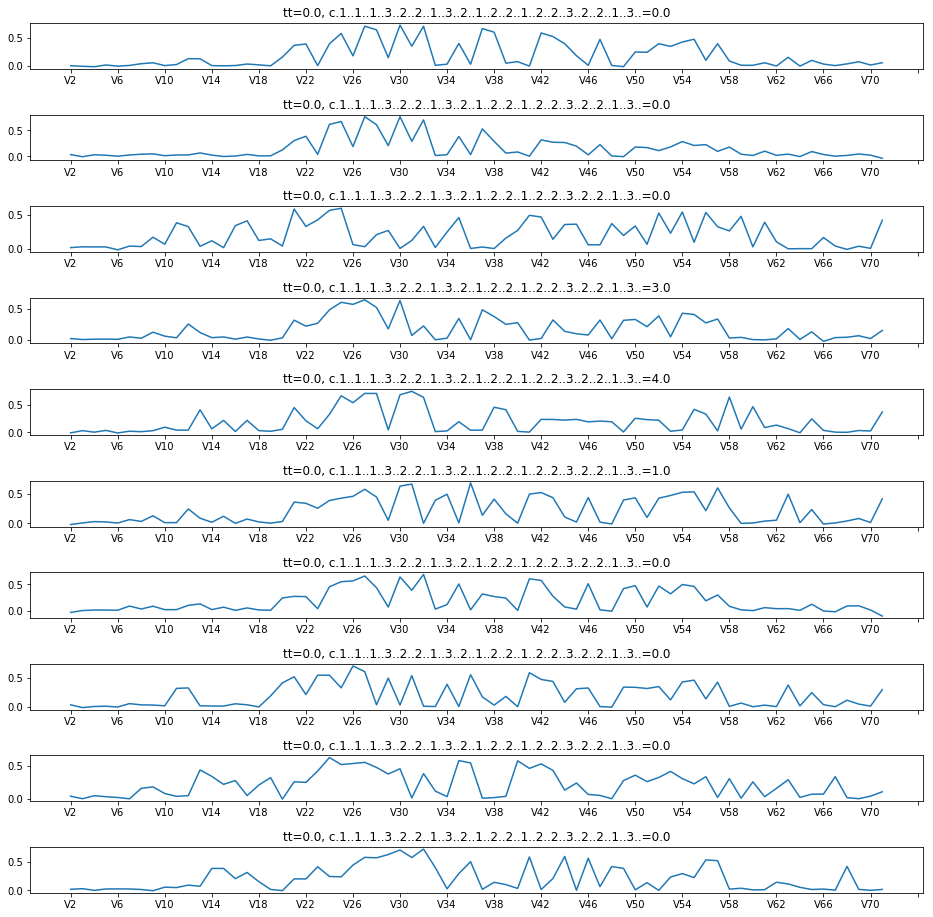

In [22]:
# take only V* columns
values = df_train.filter(regex="V")

n=10
fig,ax = plt.subplots(n,1,figsize=(16,16))
for i in range(n):
    ax[i].plot(values.iloc[i])
    
    tt=df_train.iloc[i]["tt"]
    c=df_train.iloc[i]["c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3.."]
    
    title="tt={}, c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..={}".format(tt,c)
    ax[i].set_title(title)
    
    # plot fewer ticks
    ax[i].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)



In [23]:
BavarianCrops

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V64,V65,V66,V67,V68,V69,V70,V71,c.1..1..1..3..2..2..1..3..2..1..2..2..1..2..2..3..2..2..1..3..,tt
0,0.008779,-0.001401,-0.009147,0.021795,0.001504,0.014150,0.044235,0.060912,0.010621,0.030033,...,0.002249,0.103150,0.037784,0.010899,0.041117,0.079121,0.021529,0.061546,0,0.0
1,0.033832,-0.007393,0.030412,0.020847,0.002418,0.026243,0.040848,0.047685,0.012226,0.026289,...,-0.004443,0.091951,0.035301,0.002930,0.018137,0.045654,0.022954,-0.037380,0,0.0
2,0.019428,0.031671,0.029500,0.030011,-0.013549,0.042078,0.035217,0.173853,0.069770,0.387501,...,0.004614,0.003670,0.169037,0.042935,-0.006826,0.039987,0.008837,0.426318,0,0.0
3,0.025767,0.010899,0.016418,0.017403,0.014533,0.052124,0.030727,0.128017,0.064192,0.038889,...,0.013031,0.132933,-0.018497,0.041687,0.046933,0.071237,0.025904,0.154696,3,0.0
4,-0.007725,0.032195,0.004844,0.036198,-0.009359,0.022026,0.013450,0.031341,0.093298,0.042227,...,-0.006231,0.243207,0.036697,0.005109,0.001923,0.034219,0.025867,0.366552,4,0.0
5,-0.018542,0.007825,0.030913,0.025098,0.006391,0.064659,0.033975,0.129420,0.013320,0.013531,...,0.012724,0.235723,-0.011043,0.007949,0.041598,0.084170,0.014970,0.418592,1,0.0
6,-0.032686,0.003463,0.012400,0.012996,0.008941,0.088407,0.032471,0.085572,0.019788,0.020808,...,0.007538,0.122980,-0.004891,-0.020076,0.089772,0.093133,0.013048,-0.101649,0,0.0
7,0.037558,-0.010206,0.008964,0.013565,0.000070,0.057734,0.036770,0.033446,0.019982,0.318338,...,0.018366,0.245872,0.040123,0.005087,0.115813,0.050147,0.015388,0.296864,0,0.0
8,0.043836,0.007044,0.051540,0.036817,0.025485,0.005582,0.161566,0.184241,0.084555,0.042243,...,0.025791,0.075049,0.075228,0.337736,0.023590,0.006901,0.045444,0.110656,0,0.0
9,0.021239,0.032069,0.002515,0.026787,0.027869,0.026573,0.017316,-0.004094,0.058521,0.051465,...,0.055632,0.017544,0.024859,0.005724,0.424049,0.019368,0.002984,0.018826,0,0.0
